Epoch [1/20], Base Ingredients Train Loss: 0.3270, Base Ingredients Train Accuracy: 0.8679, Dishes Train Loss: 2.0740, Dishes Train Accuracy: 0.3224, Base Ingredients Validation Loss: 0.2672, Base Ingredients Validation Accuracy: 0.8992, Dishes Validation Loss: 1.6626, Dishes Validation Accuracy: 0.5412, Base Ingredients Test Loss: 0.2571, Base Ingredients Test Accuracy: 0.9045, Dishes Test Loss: 1.6581, Dishes Test Accuracy: 0.5559
Epoch [2/20], Base Ingredients Train Loss: 0.2586, Base Ingredients Train Accuracy: 0.8955, Dishes Train Loss: 1.3617, Dishes Train Accuracy: 0.6345, Base Ingredients Validation Loss: 0.2407, Base Ingredients Validation Accuracy: 0.8957, Dishes Validation Loss: 1.3234, Dishes Validation Accuracy: 0.6165, Base Ingredients Test Loss: 0.2302, Base Ingredients Test Accuracy: 0.9017, Dishes Test Loss: 1.2952, Dishes Test Accuracy: 0.6294
Epoch [3/20], Base Ingredients Train Loss: 0.2302, Base Ingredients Train Accuracy: 0.9055, Dishes Train Loss: 1.0480, Dishes 

Epoch [20/20], Base Ingredients Train Loss: 0.1565, Base Ingredients Train Accuracy: 0.9349, Dishes Train Loss: 0.4508, Dishes Train Accuracy: 0.8721, Base Ingredients Validation Loss: 0.1849, Base Ingredients Validation Accuracy: 0.9172, Dishes Validation Loss: 0.8240, Dishes Validation Accuracy: 0.7348, Base Ingredients Test Loss: 0.1830, Base Ingredients Test Accuracy: 0.9262, Dishes Test Loss: 0.8308, Dishes Test Accuracy: 0.7252


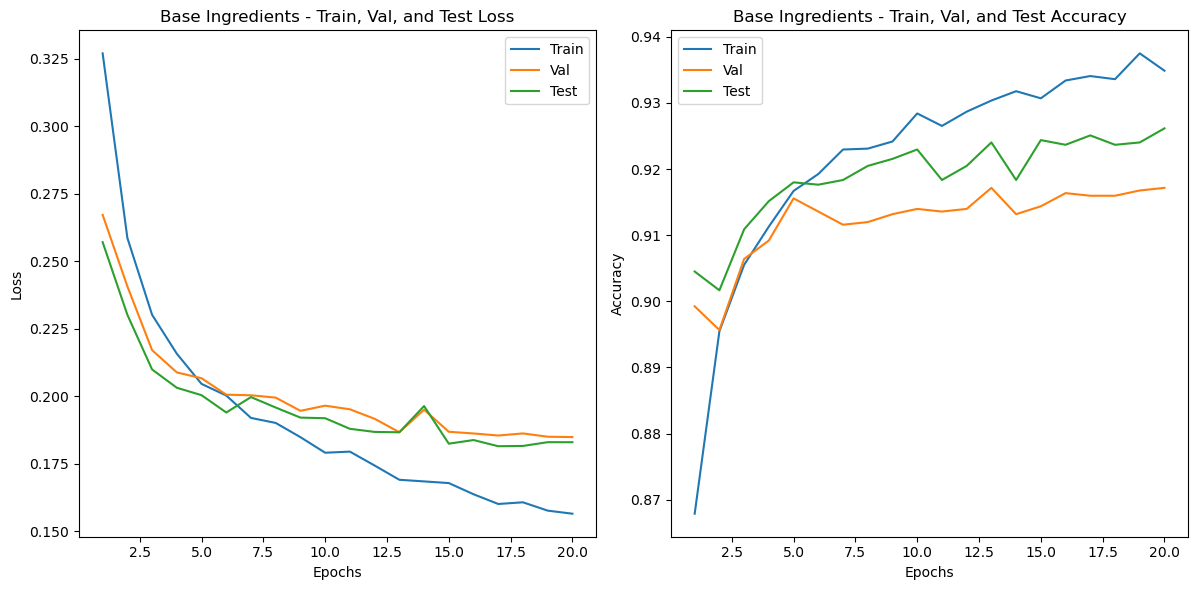

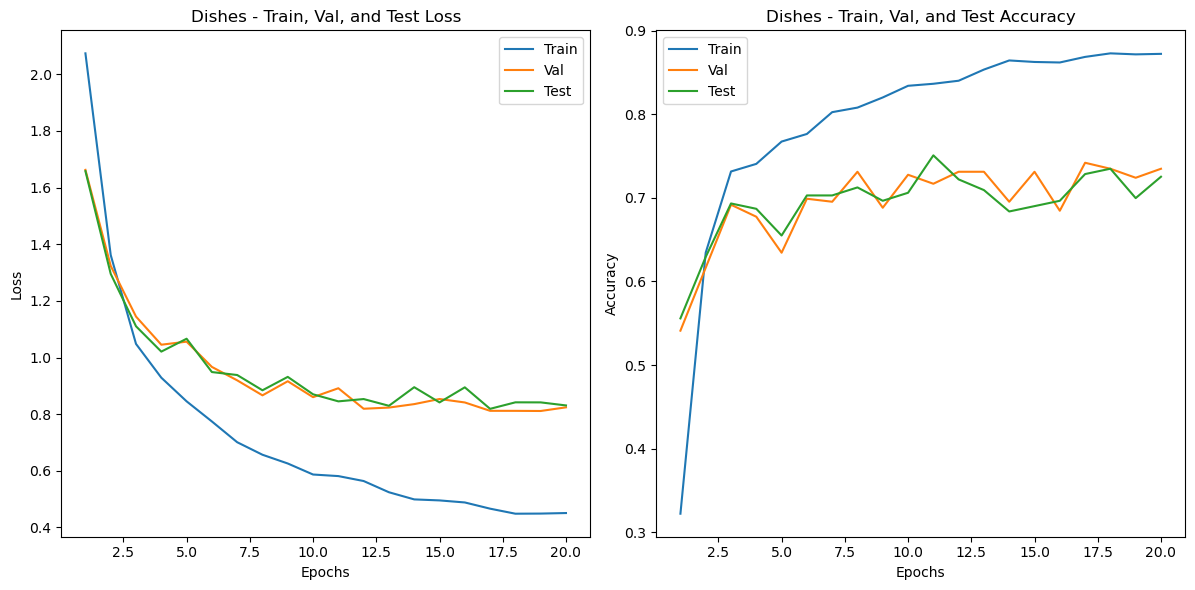

In [24]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models import resnet50, ResNet50_Weights

# Definir transformaciones de datos
transform_rgb = transforms.Compose([
    transforms.Resize((224, 224)),  # Cambiar tamaño de la imagen
    transforms.ToTensor(),  # Convertir imagen a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizar valores de los pixeles
])

# Cargar los nombres de los grupos de comida
with open("MAFood121/annotations/foodgroups.txt", "r") as f:
    food_groups = f.read().splitlines()

# Cargar los ingredientes base
with open("MAFood121/annotations/baseIngredients.txt", "r") as f:
    base_ingredients = f.read().splitlines()

# Cargar los platos de comida
with open("MAFood121/annotations/dishes.txt", "r") as f:
    dishes = f.read().splitlines()

# Crear un diccionario para mapear los nombres de los grupos de comida a sus índices correspondientes
food_groups_dict = {food_group: idx for idx, food_group in enumerate(food_groups)}

# Crear un diccionario para mapear los nombres de los ingredientes base a sus índices correspondientes
base_ingredients_dict = {ingredient: idx for idx, ingredient in enumerate(base_ingredients)}

# Crear un diccionario para mapear los nombres de los platos de comida a sus índices correspondientes
dishes_dict = {dish: idx for idx, dish in enumerate(dishes)}

# Clase para el dataset multi-label
class MAFood121MultiLabelDataset(Dataset):
    def __init__(self, txt_path, lbls_ff_txt_path, dishes_txt_path, food_groups_dict, base_ingredients_dict, dishes_dict, transform=None):
        self.txt_path = txt_path
        self.lbls_ff_txt_path = lbls_ff_txt_path
        self.dishes_txt_path = dishes_txt_path
        self.food_groups_dict = food_groups_dict
        self.base_ingredients_dict = base_ingredients_dict
        self.dishes_dict = dishes_dict
        self.transform = transform
        self.data = self._read_txt_file(txt_path)
        self.labels_ff = self._read_lbls_ff_txt_file(lbls_ff_txt_path)
        self.labels_dishes = self._read_dishes_txt_file(dishes_txt_path)

    def _read_txt_file(self, file_path):
        with open(file_path, "r") as f:
            lines = f.read().splitlines()
        return lines

    def _read_lbls_ff_txt_file(self, file_path):
        with open(file_path, "r") as f:
            lbls_ff_indices = [int(line) for line in f.read().splitlines()]
        return lbls_ff_indices

    def _read_dishes_txt_file(self, file_path):
        with open(file_path, "r") as f:
            dishes_indices = [int(line) for line in f.read().splitlines()]
        return dishes_indices

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_name = self.data[index]
        img_path = os.path.join("MAFood121/images", img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        label_ff_idx = self.labels_ff[index]
        label_ff = food_groups_dict[food_groups[label_ff_idx]]

        # Obtener los ingredientes base del foodgroup actual
        base_ingredients_idx = [base_ingredients_dict[ingredient] for ingredient in food_groups[label_ff_idx].split(',')]
        label_base_ingredients = torch.zeros(len(base_ingredients))
        label_base_ingredients[base_ingredients_idx] = 1

        # Obtener el plato de comida
        label_dish_idx = self.labels_dishes[index]
        label_dish = dishes_dict[dishes[label_dish_idx]]

        return image, label_ff, label_base_ingredients, label_dish

# Cargar los datos del conjunto de entrenamiento
train_txt_path = "MAFood121/annotations/train.txt"
train_lbls_ff_txt_path = "MAFood121/annotations/train_lbls_ff.txt"
train_dishes_txt_path = "MAFood121/annotations/train_lbls_d.txt"
train_dataset = MAFood121MultiLabelDataset(train_txt_path, train_lbls_ff_txt_path, train_dishes_txt_path,
                                          food_groups_dict, base_ingredients_dict, dishes_dict, transform_rgb)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Cargar los datos del conjunto de validación
val_txt_path = "MAFood121/annotations/val.txt"
val_lbls_ff_txt_path = "MAFood121/annotations/val_lbls_ff.txt"
val_dishes_txt_path = "MAFood121/annotations/val_lbls_d.txt"
val_dataset = MAFood121MultiLabelDataset(val_txt_path, val_lbls_ff_txt_path, val_dishes_txt_path,
                                        food_groups_dict, base_ingredients_dict, dishes_dict, transform_rgb)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Cargar los datos del conjunto de prueba
test_txt_path = "MAFood121/annotations/test.txt"
test_lbls_ff_txt_path = "MAFood121/annotations/test_lbls_ff.txt"
test_dishes_txt_path = "MAFood121/annotations/test_lbls_d.txt"
test_dataset = MAFood121MultiLabelDataset(test_txt_path, test_lbls_ff_txt_path, test_dishes_txt_path,
                                         food_groups_dict, base_ingredients_dict, dishes_dict, transform_rgb)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class Ontology_layer(nn.Module):
    def __init__(self, ontology_file, device):
        super(Ontology_layer, self).__init__()
        
        self.device = device
        # Cargar los datos desde los archivos CSV
        self.ontology_file = pd.read_csv("ontologia_mexican.csv", index_col=0)
        
        # Convertir el DataFrame de Pandas a un array de NumPy
        ontology_numpy = self.ontology_file.to_numpy()
        
        # Convertir el array de NumPy a un tensor de PyTorch
        self.ontology_layer = torch.from_numpy(ontology_numpy).float().to(self.device) [None,:,:]
        
    def forward(self, dishes, ingredients):
        dishes = torch.softmax(dishes, dim=1)
        ingredients = torch.sigmoid(ingredients)
        
        # Transponer dishes
        dishes_e = dishes[:,:, None].to(self.device)
        
        dishes_t = torch.transpose(dishes_e, 1, 2)

        # Repetir dishes_t para que tenga la misma forma que ontology_layer
        dishes_t_re = dishes_t.repeat_interleave(9, 1)

        # Calcular el producto punto entre dishes_t_re y ontology_layer
        ont_p = dishes_t_re * self.ontology_layer      

        # Sumar a lo largo de la última dimensión
        output = torch.sum(ont_p, -1)

        # Multiplicar ingredients por output
        ingredients_m = ingredients.to(self.device) * output

        return ingredients_m

# Configuración de GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definir la arquitectura del modelo multi-label utilizando ResNet-50
class MyMultiTaskModel(nn.Module):
    def __init__(self, num_base_ingredients, num_dishes, ontology_layer):
        super(MyMultiTaskModel, self).__init__()

        # Cargar el modelo ResNet-50 pre-entrenado en ImageNet
        resnet50 = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        
        # Deshabilitar el entrenamiento de las capas existentes
        for param in resnet50.parameters():
            param.requires_grad = False

        # Extraer el clasificador de ResNet-50 y ajustar la salida para las clases de interés
        self.features = nn.Sequential(*list(resnet50.children())[:-1])  # Todas las capas excepto la capa de clasificación
        in_features = resnet50.fc.in_features
        
        # Capa Dropout
        self.dropout = nn.Dropout(0.1)

        self.classifier_base_ingredients = nn.Linear(in_features, num_base_ingredients)
        self.classifier_dishes = nn.Linear(in_features, num_dishes)
        
        # Conectar la capa OntologyLayer pasando la instancia de OntologyLayer
        self.ontology_layer = ontology_layer        

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        
        # Aplicar Dropout
        x = self.dropout(x)
        
        out_base_ingredients = self.classifier_base_ingredients(x)
        out_dishes = self.classifier_dishes(x)
        
        ingredients_m = self.ontology_layer(out_dishes, out_base_ingredients)        
        
        return out_base_ingredients, ingredients_m, out_dishes

# Creación del modelo y envío a GPU si está disponible
ontology_layer = Ontology_layer("ontologia_mexican.csv", device)
model = MyMultiTaskModel(num_base_ingredients=len(base_ingredients),
                         num_dishes=len(dishes), ontology_layer=ontology_layer)
model.to(device)

# Definición de la función de pérdida y optimizador para multi-label
criterion_base_ingredients = nn.BCEWithLogitsLoss()
criterion_dishes = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

# Entrenamiento del modelo multitarea
train_losses_base = []
train_losses_dishes = []
train_accuracies_base = []
train_accuracies_dishes = []

val_losses_base = []
val_losses_dishes = []
val_accuracies_base = []
val_accuracies_dishes = []

test_losses_base = []
test_losses_dishes = []
test_accuracies_base = []
test_accuracies_dishes = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss_base = 0.0
    running_train_loss_dishes = 0.0
    correct_train_base = 0
    correct_train_dishes = 0
    total_train = 0

    for images, labels_ff, labels_base, labels_dishes in train_loader:
        images = images.to(device)
        labels_ff = labels_ff.to(device)
        labels_base = labels_base.to(device)
        labels_dishes = labels_dishes.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs_base, ingredients_m, outputs_dishes = model(images)

        # Calculate loss for each task
        loss_base = criterion_base_ingredients(outputs_base, labels_base)
        loss_dishes = criterion_dishes(outputs_dishes, labels_dishes)

        # Weighted sum of losses
        loss = loss_base + loss_dishes

        # Backward pass y optimización
        loss.backward()
        optimizer.step()

        running_train_loss_base += loss_base.item()
        running_train_loss_dishes += loss_dishes.item()

        # Calculate accuracy for each task
        correct_train_base += torch.sum(torch.round(torch.sigmoid(outputs_base)) == labels_base).item()

        _, predicted_dishes = torch.max(outputs_dishes.data, 1)
        correct_train_dishes += (predicted_dishes == labels_dishes).sum().item()

        total_train += labels_ff.size(0)

    # Imprimir loss y accuracy promedio en cada época para el conjunto de entrenamiento
    avg_train_loss_base = running_train_loss_base / len(train_loader)
    avg_train_loss_dishes = running_train_loss_dishes / len(train_loader)

    avg_train_accuracy_base = correct_train_base / (total_train * len(base_ingredients))
    avg_train_accuracy_dishes = correct_train_dishes / total_train

    # Validación del modelo
    model.eval()
    running_val_loss_base = 0.0
    running_val_loss_dishes = 0.0
    correct_val_base = 0
    correct_val_dishes = 0
    total_val = 0

    with torch.no_grad():
        for images, labels_ff, labels_base, labels_dishes in val_loader:
            images = images.to(device)
            labels_ff = labels_ff.to(device)
            labels_base = labels_base.to(device)
            labels_dishes = labels_dishes.to(device)

            outputs_base, ingredients_m, outputs_dishes = model(images)
            loss_base = criterion_base_ingredients(outputs_base, labels_base)
            loss_dishes = criterion_dishes(outputs_dishes, labels_dishes)

            running_val_loss_base += loss_base.item()
            running_val_loss_dishes += loss_dishes.item()

            # Calculate accuracy for each task
            correct_val_base += torch.sum(torch.round(torch.sigmoid(outputs_base)) == labels_base).item()

            _, predicted_dishes = torch.max(outputs_dishes.data, 1)
            correct_val_dishes += (predicted_dishes == labels_dishes).sum().item()

            total_val += labels_ff.size(0)

    # Imprimir loss y accuracy promedio en validación
    avg_val_loss_base = running_val_loss_base / len(val_loader)
    avg_val_loss_dishes = running_val_loss_dishes / len(val_loader)

    avg_val_accuracy_base = correct_val_base / (total_val * len(base_ingredients))
    avg_val_accuracy_dishes = correct_val_dishes / total_val
    
    # Prueba del modelo en el conjunto de prueba
    model.eval()
    running_test_loss_base = 0.0
    running_test_loss_dishes = 0.0
    correct_test_base = 0
    correct_test_dishes = 0
    total_test = 0

    with torch.no_grad():
        for images, labels_ff, labels_base, labels_dishes in test_loader:
            images = images.to(device)
            labels_ff = labels_ff.to(device)
            labels_base = labels_base.to(device)
            labels_dishes = labels_dishes.to(device)

            outputs_base, ingredients_m, outputs_dishes = model(images)
            loss_base = criterion_base_ingredients(outputs_base, labels_base)
            loss_dishes = criterion_dishes(outputs_dishes, labels_dishes)

            running_test_loss_base += loss_base.item()
            running_test_loss_dishes += loss_dishes.item()

            # Calculate accuracy for each task
            correct_test_base += torch.sum(torch.round(torch.sigmoid(outputs_base)) == labels_base).item()

            _, predicted_dishes = torch.max(outputs_dishes.data, 1)
            correct_test_dishes += (predicted_dishes == labels_dishes).sum().item()

            total_test += labels_ff.size(0)

    # Imprimir loss y accuracy en prueba
    avg_test_loss_base = running_test_loss_base / len(test_loader)
    avg_test_loss_dishes = running_test_loss_dishes / len(test_loader)

    avg_test_accuracy_base = correct_test_base / (total_test * len(base_ingredients))
    avg_test_accuracy_dishes = correct_test_dishes / total_test
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Base Ingredients Train Loss: {avg_train_loss_base:.4f}, Base Ingredients Train Accuracy: {avg_train_accuracy_base:.4f}, Dishes Train Loss: {avg_train_loss_dishes:.4f}, Dishes Train Accuracy: {avg_train_accuracy_dishes:.4f}, "
          f"Base Ingredients Validation Loss: {avg_val_loss_base:.4f}, Base Ingredients Validation Accuracy: {avg_val_accuracy_base:.4f}, Dishes Validation Loss: {avg_val_loss_dishes:.4f}, Dishes Validation Accuracy: {avg_val_accuracy_dishes:.4f}, "
          f"Base Ingredients Test Loss: {avg_test_loss_base:.4f}, Base Ingredients Test Accuracy: {avg_test_accuracy_base:.4f}, Dishes Test Loss: {avg_test_loss_dishes:.4f}, Dishes Test Accuracy: {avg_test_accuracy_dishes:.4f}")    

    train_losses_base.append(avg_train_loss_base)
    train_losses_dishes.append(avg_train_loss_dishes)

    train_accuracies_base.append(avg_train_accuracy_base)
    train_accuracies_dishes.append(avg_train_accuracy_dishes)

    val_losses_base.append(avg_val_loss_base)
    val_losses_dishes.append(avg_val_loss_dishes)

    val_accuracies_base.append(avg_val_accuracy_base)
    val_accuracies_dishes.append(avg_val_accuracy_dishes)

    test_losses_base.append(avg_test_loss_base)
    test_losses_dishes.append(avg_test_loss_dishes)

    test_accuracies_base.append(avg_test_accuracy_base)
    test_accuracies_dishes.append(avg_test_accuracy_dishes)

# Graficar loss y accuracy en entrenamiento, validación y prueba para los tres modelos
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses_base, label='Train')
plt.plot(epochs, val_losses_base, label='Val')
plt.plot(epochs, test_losses_base, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Base Ingredients - Train, Val, and Test Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies_base, label='Train')
plt.plot(epochs, val_accuracies_base, label='Val')
plt.plot(epochs, test_accuracies_base, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Base Ingredients - Train, Val, and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses_dishes, label='Train')
plt.plot(epochs, val_losses_dishes, label='Val')
plt.plot(epochs, test_losses_dishes, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Dishes - Train, Val, and Test Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies_dishes, label='Train')
plt.plot(epochs, val_accuracies_dishes, label='Val')
plt.plot(epochs, test_accuracies_dishes, label='Test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Dishes - Train, Val, and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

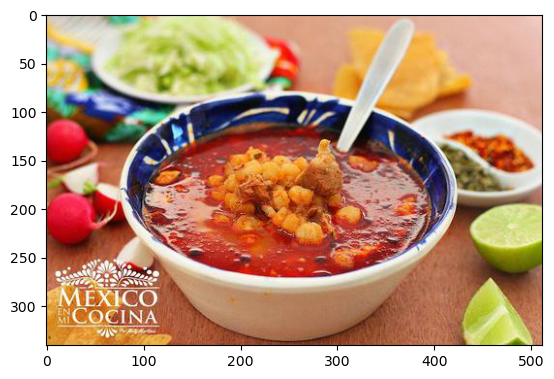

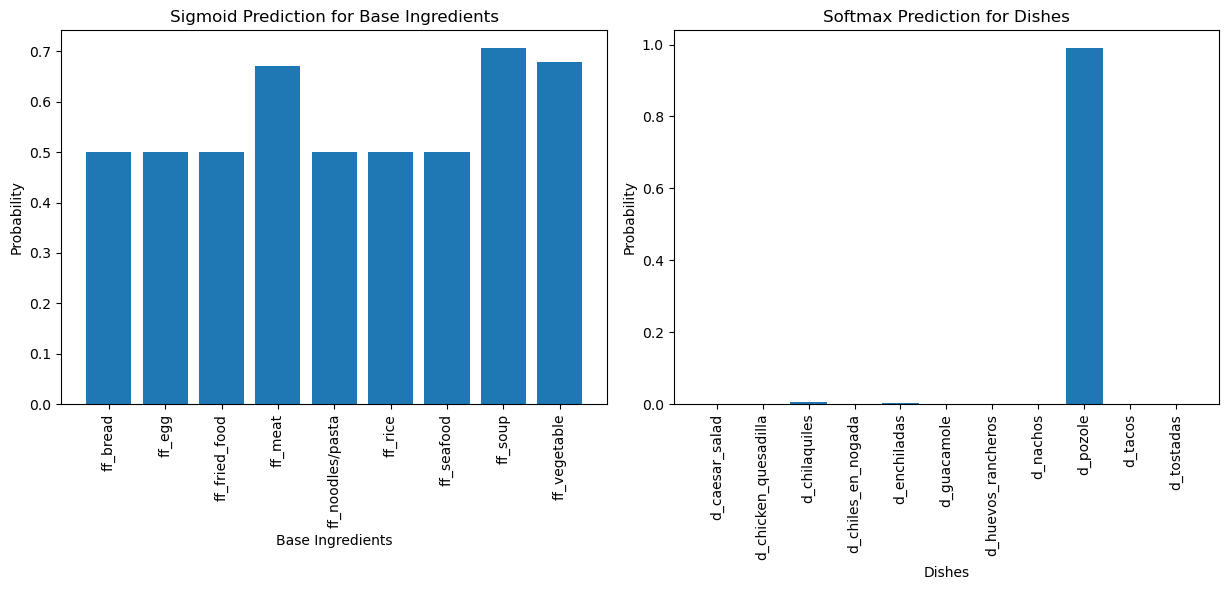


Predicciones ML, ingredients (Sigmoid):
[0.50079453 0.50000334 0.50005084 0.67004424 0.5        0.5
 0.5        0.70647573 0.6798063 ]

Predicciones SL, dishes (Softmax):
[0.         0.         0.00490784 0.         0.00201652 0.
 0.         0.         0.9900574  0.         0.        ]


In [30]:
# Cargar una imagen de prueba
img_path = '56_1.jpg'
img = Image.open(img_path).convert('RGB')
plt.imshow(img)

# Resize image and convert to tensor
IMG_SIZE = 224  # Tamaño de imagen esperado por ResNet-50
transform = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()])
img = transform(img)
img = img.unsqueeze(0)

# Obtener predicciones del modelo para ambos ingredientes base, grupos de comida y plato de comida
model.eval()
with torch.no_grad():
    preds_ff, preds_base, preds_dishes = model(img.to(device))

# Aplicar sigmoid a las predicciones de ingredientes base
preds_base = torch.sigmoid(preds_base)
preds_base = preds_base.cpu().numpy()

# Establecer los valores por debajo de 0.5 en 0
preds_base[preds_base < 0.01] = 0

# Aplicar softmax a las predicciones de plato de comida
preds_dishes = torch.nn.functional.softmax(preds_dishes, dim=1)
preds_dishes = preds_dishes.cpu().numpy()

# Establecer los valores por debajo de 0.2 en 0
preds_dishes[preds_dishes < 0.001] = 0

# Graficar los resultados de la predicción para ambos ingredientes base, grupos de comida y plato de comida
preds_base = preds_base.squeeze()
preds_dishes = preds_dishes.squeeze()

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 2)
plt.bar(base_ingredients, preds_base)
plt.title('Sigmoid Prediction for Base Ingredients')
plt.xticks(rotation=90)
plt.xlabel('Base Ingredients')
plt.ylabel('Probability')

plt.subplot(1, 3, 3)
plt.bar(dishes, preds_dishes)
plt.title('Softmax Prediction for Dishes')
plt.xticks(rotation=90)
plt.xlabel('Dishes')
plt.ylabel('Probability')

plt.tight_layout()
plt.show()

# Imprimir predicciones ML (Sigmoid) y SL (Softmax)
print("\nPredicciones ML, ingredients (Sigmoid):")
print(preds_base.squeeze())

print("\nPredicciones SL, dishes (Softmax):")
print(preds_dishes.squeeze())

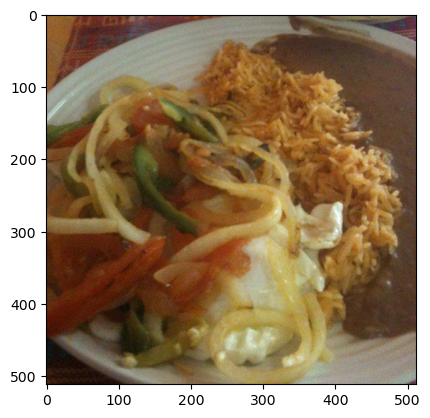

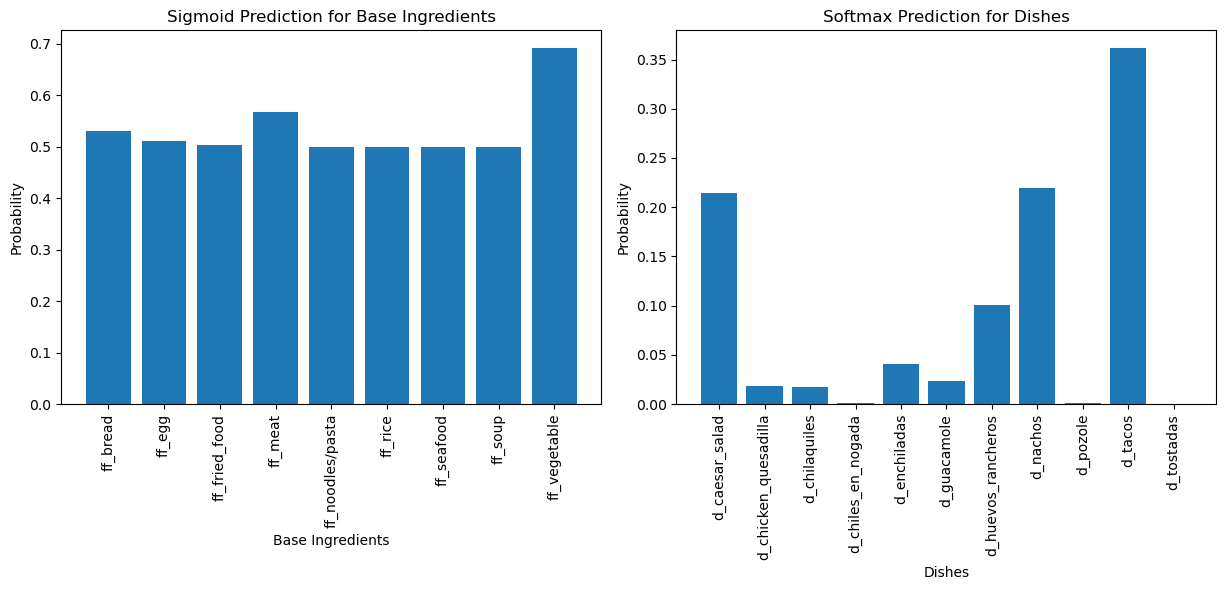


Predicciones ML, ingredients (Sigmoid):
[0.5312465  0.51085633 0.5034466  0.56772155 0.5        0.5
 0.5        0.5000021  0.6914912 ]

Predicciones SL, dishes (Softmax):
[0.2148723  0.01877387 0.01733583 0.00107066 0.04026858 0.02378089
 0.1009144  0.21925174 0.00146838 0.3615909  0.        ]


In [33]:
# Cargar una imagen de prueba
img_path = '473481.jpg'
img = Image.open(img_path).convert('RGB')
plt.imshow(img)

# Resize image and convert to tensor
IMG_SIZE = 224  # Tamaño de imagen esperado por ResNet-50
transform = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()])
img = transform(img)
img = img.unsqueeze(0)

# Obtener predicciones del modelo para ambos ingredientes base, grupos de comida y plato de comida
model.eval()
with torch.no_grad():
    preds_ff, preds_base, preds_dishes = model(img.to(device))

# Aplicar sigmoid a las predicciones de ingredientes base
preds_base = torch.sigmoid(preds_base)
preds_base = preds_base.cpu().numpy()

# Establecer los valores por debajo de 0.5 en 0
preds_base[preds_base < 0.001] = 0

# Aplicar softmax a las predicciones de plato de comida
preds_dishes = torch.nn.functional.softmax(preds_dishes, dim=1)
preds_dishes = preds_dishes.cpu().numpy()

# Establecer los valores por debajo de 0.2 en 0
preds_dishes[preds_dishes < 0.001] = 0

# Graficar los resultados de la predicción para ambos ingredientes base, grupos de comida y plato de comida
preds_base = preds_base.squeeze()
preds_dishes = preds_dishes.squeeze()

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 2)
plt.bar(base_ingredients, preds_base)
plt.title('Sigmoid Prediction for Base Ingredients')
plt.xticks(rotation=90)
plt.xlabel('Base Ingredients')
plt.ylabel('Probability')

plt.subplot(1, 3, 3)
plt.bar(dishes, preds_dishes)
plt.title('Softmax Prediction for Dishes')
plt.xticks(rotation=90)
plt.xlabel('Dishes')
plt.ylabel('Probability')

plt.tight_layout()
plt.show()

# Imprimir predicciones ML (Sigmoid) y SL (Softmax)
print("\nPredicciones ML, ingredients (Sigmoid):")
print(preds_base.squeeze())

print("\nPredicciones SL, dishes (Softmax):")
print(preds_dishes.squeeze())